## Image classification with Convolutional Neural Networks

In [216]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [217]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [218]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [219]:
PATH = "data/plant-seedlings-classification"

In [220]:
torch.cuda.is_available()

True

In [221]:
torch.backends.cudnn.enabled

True

## First look at pictures

In [222]:
!ls {PATH}

images	sample_submission.csv	   subm  test.zip  train      train.zip
models	sample_submission.csv.zip  test  tmp	   train.csv


In [223]:
!rm -r {PATH}/test {PATH}/train {PATH}/images

In [224]:
!unzip {PATH}/test.zip -d {PATH}

Archive:  data/plant-seedlings-classification/test.zip
   creating: data/plant-seedlings-classification/test/
  inflating: data/plant-seedlings-classification/test/c0461776c.png  
  inflating: data/plant-seedlings-classification/test/4bbfd1e05.png  
  inflating: data/plant-seedlings-classification/test/1d0cbd819.png  
  inflating: data/plant-seedlings-classification/test/93079d970.png  
  inflating: data/plant-seedlings-classification/test/856f2910a.png  
  inflating: data/plant-seedlings-classification/test/976e4e079.png  
  inflating: data/plant-seedlings-classification/test/b31292706.png  
  inflating: data/plant-seedlings-classification/test/29bab7cad.png  
  inflating: data/plant-seedlings-classification/test/37297a64c.png  
  inflating: data/plant-seedlings-classification/test/f2dc546ca.png  
  inflating: data/plant-seedlings-classification/test/b6a3f7876.png  
  inflating: data/plant-seedlings-classification/test/8874bba69.png  
  inflating: data/plant-seedlings-classification/t

  inflating: data/plant-seedlings-classification/test/3eda9cbb6.png  
  inflating: data/plant-seedlings-classification/test/17a78fb44.png  
  inflating: data/plant-seedlings-classification/test/866be78b0.png  
  inflating: data/plant-seedlings-classification/test/7b52585da.png  
  inflating: data/plant-seedlings-classification/test/8c9953903.png  
  inflating: data/plant-seedlings-classification/test/b3d6fdb80.png  
  inflating: data/plant-seedlings-classification/test/33748968f.png  
  inflating: data/plant-seedlings-classification/test/00ef713a8.png  
  inflating: data/plant-seedlings-classification/test/c10ccbd82.png  
  inflating: data/plant-seedlings-classification/test/6df8e31ea.png  
  inflating: data/plant-seedlings-classification/test/52dc7a4d6.png  
  inflating: data/plant-seedlings-classification/test/c6b76307d.png  
  inflating: data/plant-seedlings-classification/test/cf90fc52d.png  
  inflating: data/plant-seedlings-classification/test/59358cd44.png  
  inflating: data/pl

  inflating: data/plant-seedlings-classification/test/86f08e6d1.png  
  inflating: data/plant-seedlings-classification/test/29ce426a1.png  
  inflating: data/plant-seedlings-classification/test/ef74dbcad.png  
  inflating: data/plant-seedlings-classification/test/486e59179.png  
  inflating: data/plant-seedlings-classification/test/c10db7ae2.png  
  inflating: data/plant-seedlings-classification/test/abf8b0772.png  
  inflating: data/plant-seedlings-classification/test/32b42c120.png  
  inflating: data/plant-seedlings-classification/test/98062cd87.png  
  inflating: data/plant-seedlings-classification/test/085974290.png  
  inflating: data/plant-seedlings-classification/test/3d65168c2.png  
  inflating: data/plant-seedlings-classification/test/5b63dcc21.png  
  inflating: data/plant-seedlings-classification/test/24d78df74.png  
  inflating: data/plant-seedlings-classification/test/d488a4fe1.png  
  inflating: data/plant-seedlings-classification/test/c88ebfb47.png  
  inflating: data/pl

  inflating: data/plant-seedlings-classification/test/3d38a87bc.png  
  inflating: data/plant-seedlings-classification/test/1191ba346.png  
  inflating: data/plant-seedlings-classification/test/b6f3d8b5d.png  
  inflating: data/plant-seedlings-classification/test/43ede9de9.png  
  inflating: data/plant-seedlings-classification/test/2d9c798f9.png  
  inflating: data/plant-seedlings-classification/test/24d36c52c.png  
  inflating: data/plant-seedlings-classification/test/172f9b10b.png  
  inflating: data/plant-seedlings-classification/test/16fd2e01a.png  
  inflating: data/plant-seedlings-classification/test/0ae6668fa.png  
  inflating: data/plant-seedlings-classification/test/a74bf916d.png  
  inflating: data/plant-seedlings-classification/test/6a47821f9.png  
  inflating: data/plant-seedlings-classification/test/0dba99002.png  
  inflating: data/plant-seedlings-classification/test/f445fe6fb.png  
  inflating: data/plant-seedlings-classification/test/fd925f542.png  
  inflating: data/pl

In [225]:
!unzip {PATH}/train.zip -d {PATH}

Archive:  data/plant-seedlings-classification/train.zip
   creating: data/plant-seedlings-classification/train/
   creating: data/plant-seedlings-classification/train/Fat Hen/
  inflating: data/plant-seedlings-classification/train/Fat Hen/5bdfa3a44.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/a86b9c0cd.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/f3f6559bf.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/946b48f62.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/4d7fd4020.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/2509e5bc5.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/e2462573b.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/7e98e4aa6.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/075cb6666.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/b43d0a350.png  
  inflating: data/plant-seedlings-

  inflating: data/plant-seedlings-classification/train/Fat Hen/10553b4e8.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/a1a3e2515.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/cca9e1864.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/88ea1ed2a.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/61fd68900.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/5357849ba.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/b8e176ae8.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/ccb763490.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/2d6ffd537.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/a5aa3564a.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/6f099ece0.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/2b16fb022.png  
  inflating: data/plant-seedlings-classification/tra

  inflating: data/plant-seedlings-classification/train/Fat Hen/f09c51a67.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/14f7687d1.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/2df7f8513.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/e6befd0af.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/4a320f8be.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/19fc23481.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/62f3abbd1.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/3572c1951.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/67659c7df.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/5f6634fa4.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/84097b0b7.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/8a8b1f0fd.png  
  inflating: data/plant-seedlings-classification/tra

  inflating: data/plant-seedlings-classification/train/Fat Hen/0c5368b03.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/b4e6ee3d2.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/704b0fe2c.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/23525c578.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/07636139b.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/03100eb7e.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/614b0792a.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/91c33cc1c.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/4f2f35ea4.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/077190c7a.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/08fe5538d.png  
  inflating: data/plant-seedlings-classification/train/Fat Hen/ac88a6662.png  
  inflating: data/plant-seedlings-classification/tra

  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/6749e8eec.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/23125a26e.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/8d3505642.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/c2922dd4b.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/b53ebbdc8.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/c97427ee2.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/a11144563.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/4507d5e15.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/d7314844c.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/3cdca6a6c.png  
  inflating: data/plant-seedli

  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/7c3ca61ff.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/605478787.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/f46902555.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/3810c2e11.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/6c7043cc5.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/c2143cbb6.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/876391c4f.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/9fe156262.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/da462b870.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/ebbadc4c2.png  
  inflating: data/plant-seedli

  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/78730a816.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/436e5809f.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/d3e90a2e9.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/ad8b28544.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/3431fcef9.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/46c4aeda2.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/ac4df2b40.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/487599b7f.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/19f14f508.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/076b550b6.png  
  inflating: data/plant-seedli

  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/6b666de44.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/d9ff280f1.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/7be34ad47.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/ea39d1bf1.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/ae9b5d027.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/c423a70c3.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/9f4b3c440.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/460ac5645.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/7e8c89d30.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/816965c05.png  
  inflating: data/plant-seedli

  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/018c28574.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/726ae59a2.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/18a460203.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/6af7caae2.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/00e049fe8.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/758271672.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/a3d92fb5a.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/b0de6838e.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/e4fd7e115.png  
  inflating: data/plant-seedlings-classification/train/Small-flowered Cranesbill/2db36f1a0.png  
  inflating: data/plant-seedli

  inflating: data/plant-seedlings-classification/train/Cleavers/0bcf29af7.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/4613b263e.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/794b914bf.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/cf285e97d.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/58b68b1ea.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/8035a175e.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/ef4a36963.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/899877fe1.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/6e0fa9bcc.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/1e0caafd3.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/0a33283c7.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/db735ff97.png  
  inflating: data/plant-seedlings-classi

  inflating: data/plant-seedlings-classification/train/Cleavers/609c74407.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/2a1d10e06.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/8baf67453.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/323f03521.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/61287f47a.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/94f82e916.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/398cc8af9.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/f4248cc7f.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/0ac327873.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/944e50e37.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/1e5041183.png  
  inflating: data/plant-seedlings-classification/train/Cleavers/7a9efaf6c.png  
  inflating: data/plant-seedlings-classi

  inflating: data/plant-seedlings-classification/train/Black-grass/4cf922aea.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/fc1001932.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/2ee4dad8c.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/d8afd58f3.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/82e0d98d2.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/dde665ea5.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/25daae389.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/0050f38b3.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/f4b7ddbce.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/31f2766cb.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/4a7e7eba8.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/5e21fa6f1.png  
  in

  inflating: data/plant-seedlings-classification/train/Black-grass/26103af9c.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/e0380dff9.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/c1a625098.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/b9e36fa79.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/850a09a6b.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/355cad34c.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/ebd2350df.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/f84089a55.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/963dbc831.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/13a7f553a.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/14719a83e.png  
  inflating: data/plant-seedlings-classification/train/Black-grass/71f6e3227.png  
  in

  inflating: data/plant-seedlings-classification/train/Sugar beet/915689d7d.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/7b4682569.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/26eff1e2a.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/13726d79d.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/899e696a1.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/33ddbf2cc.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/924a65aef.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/ea2b5a53e.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/56a7b34cf.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/e0f7fb20b.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/f7ac77334.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/4fd1fe7ac.png  
  inflating: dat

  inflating: data/plant-seedlings-classification/train/Sugar beet/7c572a30a.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/8723bd1e8.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/0f1ac7c29.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/0f8a1f158.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/e832be17c.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/4c81ff749.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/e6217a0c4.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/9a8bb2fff.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/d1da687e9.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/5121d936d.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/819c6ac1d.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/b0264558c.png  
  inflating: dat

  inflating: data/plant-seedlings-classification/train/Sugar beet/58debe1da.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/6085e20a5.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/b3bac1203.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/748fd9df6.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/b41816608.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/f72176e1a.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/b0d647301.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/f1bb1de07.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/eb0418d36.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/cb5ff9c78.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/eb2b13b27.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/85f8f5ae1.png  
  inflating: dat

  inflating: data/plant-seedlings-classification/train/Sugar beet/10f06d712.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/8129d97cd.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/6090033e9.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/1cd8ef887.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/04c979351.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/84d42e202.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/341823a91.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/9040bcb5b.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/6f0536b55.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/dc351dfa4.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/56426cc09.png  
  inflating: data/plant-seedlings-classification/train/Sugar beet/5e10b3707.png  
  inflating: dat

  inflating: data/plant-seedlings-classification/train/Shepherds Purse/631cac357.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/ed2fe7bb9.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/e0bc6c676.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/ff46c64b4.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/f90b0ca05.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/05ea7f987.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/fdd0a59e3.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/7a1c3e5b8.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/c16206dca.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/688da98a7.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/905aee3f2.png  
  inflating: data/plant-seedlings-classific

  inflating: data/plant-seedlings-classification/train/Shepherds Purse/5512ca7ba.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/afb08d410.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/465fc11b5.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/840fdb281.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/bbb2fe0b4.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/f981da6df.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/d62879538.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/9617b5025.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/74be44aef.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/5f731b96c.png  
  inflating: data/plant-seedlings-classification/train/Shepherds Purse/46c449cdf.png  
  inflating: data/plant-seedlings-classific

  inflating: data/plant-seedlings-classification/train/Charlock/c97f86135.png  
  inflating: data/plant-seedlings-classification/train/Charlock/c19bc586d.png  
  inflating: data/plant-seedlings-classification/train/Charlock/9a3903864.png  
  inflating: data/plant-seedlings-classification/train/Charlock/de1dc1b00.png  
  inflating: data/plant-seedlings-classification/train/Charlock/ee4a02bf9.png  
  inflating: data/plant-seedlings-classification/train/Charlock/350a133fe.png  
  inflating: data/plant-seedlings-classification/train/Charlock/09f038ce4.png  
  inflating: data/plant-seedlings-classification/train/Charlock/f39a873f8.png  
  inflating: data/plant-seedlings-classification/train/Charlock/c45aa7507.png  
  inflating: data/plant-seedlings-classification/train/Charlock/34842c4a1.png  
  inflating: data/plant-seedlings-classification/train/Charlock/c0ae1e074.png  
  inflating: data/plant-seedlings-classification/train/Charlock/512f3e717.png  
  inflating: data/plant-seedlings-classi

  inflating: data/plant-seedlings-classification/train/Charlock/eda5cd97f.png  
  inflating: data/plant-seedlings-classification/train/Charlock/ba2cfd858.png  
  inflating: data/plant-seedlings-classification/train/Charlock/0edcd02cd.png  
  inflating: data/plant-seedlings-classification/train/Charlock/e80aaab6b.png  
  inflating: data/plant-seedlings-classification/train/Charlock/de0e95661.png  
  inflating: data/plant-seedlings-classification/train/Charlock/d8da05d11.png  
  inflating: data/plant-seedlings-classification/train/Charlock/7be37a159.png  
  inflating: data/plant-seedlings-classification/train/Charlock/6a84bdf5f.png  
  inflating: data/plant-seedlings-classification/train/Charlock/3d957e19d.png  
  inflating: data/plant-seedlings-classification/train/Charlock/9d7f4d92c.png  
  inflating: data/plant-seedlings-classification/train/Charlock/c07c67078.png  
  inflating: data/plant-seedlings-classification/train/Charlock/85637dbdc.png  
  inflating: data/plant-seedlings-classi

  inflating: data/plant-seedlings-classification/train/Charlock/c61d3ee3c.png  
  inflating: data/plant-seedlings-classification/train/Charlock/f193af8d4.png  
  inflating: data/plant-seedlings-classification/train/Charlock/f0a9c3b66.png  
  inflating: data/plant-seedlings-classification/train/Charlock/1639ed813.png  
  inflating: data/plant-seedlings-classification/train/Charlock/6a23010e3.png  
  inflating: data/plant-seedlings-classification/train/Charlock/2f75f171e.png  
  inflating: data/plant-seedlings-classification/train/Charlock/9cdf5eb74.png  
  inflating: data/plant-seedlings-classification/train/Charlock/d1b362c43.png  
  inflating: data/plant-seedlings-classification/train/Charlock/cf04964e6.png  
  inflating: data/plant-seedlings-classification/train/Charlock/dccc5c0a7.png  
  inflating: data/plant-seedlings-classification/train/Charlock/dc20df305.png  
  inflating: data/plant-seedlings-classification/train/Charlock/d733b32d8.png  
  inflating: data/plant-seedlings-classi

  inflating: data/plant-seedlings-classification/train/Charlock/7d16f8f00.png  
  inflating: data/plant-seedlings-classification/train/Charlock/ec48facfa.png  
   creating: data/plant-seedlings-classification/train/Loose Silky-bent/
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/8c796e67b.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/f9a8a0e39.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/60633ad65.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/9cf880bda.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/a60d26781.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/9589aea99.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/1db16c185.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/b9c2cd1c5.png  
  inflating: data/plant-seedlings-classification/train/Loose Si

  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/b7c642fb5.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/5f29a86e2.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/25c91550e.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/5b5ad325a.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/7d36fb3eb.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/4a0df8be4.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/f4a2acf34.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/217c20421.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/4ad784313.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/04a16ff3b.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/b3b03d5b6.png  
  inflating: data/plant-seedling

  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/93f8327c5.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/8fab11dfb.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/b2b62db50.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/2e69d1685.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/86f407dd7.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/113b4a298.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/d30fdc9aa.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/e9e0e6feb.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/dbe5c4ab1.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/3f13f9bae.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/47f57446f.png  
  inflating: data/plant-seedling

  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/d7954bb16.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/e0c207a01.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/d09db3735.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/6202edcfd.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/4c800c3db.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/3b5cbd2cb.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/44f0c7749.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/70ea37ffc.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/d260a6bc4.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/b7e5943b5.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/ce70bc8a7.png  
  inflating: data/plant-seedling

  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/c1d37bdb2.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/280af96c0.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/881498f15.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/1f5b705c0.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/2399027ab.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/2a62cd782.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/fe944dee4.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/e9ef76a8d.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/543887ef6.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/b0cebe0d0.png  
  inflating: data/plant-seedlings-classification/train/Loose Silky-bent/629d857bf.png  
  inflating: data/plant-seedling

  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/9524b09c2.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/6c2cef408.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/726c2bcb1.png  
 extracting: data/plant-seedlings-classification/train/Scentless Mayweed/872673b5f.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/bc656f071.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/fa55f4be4.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/51e71ddde.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/5186c72ca.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/45d74776a.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/b0e6ba84f.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/8b227f1b2.png  
  inflating: data/pla

  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/618922851.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/8ea94061e.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/015215883.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/163de1bde.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/9985f08e7.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/273dc0a1c.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/2bb431697.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/40eea04f4.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/6398c3458.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/2ab910bdf.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/0e978005a.png  
  inflating: data/pla

  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/523edb175.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/763ce5af0.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/e5dd11bac.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/96c6d3af6.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/275152b11.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/7ff4c69a1.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/9b5bc7b68.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/8334bb575.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/ce3bee65a.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/4487c184f.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/7b1d526d2.png  
  inflating: data/pla

  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/ae64f6530.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/395ff5971.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/04f89976a.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/5fa64f7ab.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/0efb0719f.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/1ea60c734.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/4205830a0.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/92e4b5803.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/657eccef3.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/319667b0f.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/1750dd2c8.png  
  inflating: data/pla

  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/883119ddc.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/29b4e98c4.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/f83626ff7.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/ef23c4d59.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/d1e775b97.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/9b40fd5b4.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/bf5217e5b.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/64176476e.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/712b2a926.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/7d69c71e1.png  
  inflating: data/plant-seedlings-classification/train/Scentless Mayweed/4076ae5ce.png  
  inflating: data/pla

  inflating: data/plant-seedlings-classification/train/Maize/b496ed692.png  
  inflating: data/plant-seedlings-classification/train/Maize/97da6a579.png  
  inflating: data/plant-seedlings-classification/train/Maize/50c80a5e4.png  
  inflating: data/plant-seedlings-classification/train/Maize/8d2004e7a.png  
  inflating: data/plant-seedlings-classification/train/Maize/3ad5d809c.png  
  inflating: data/plant-seedlings-classification/train/Maize/f98add892.png  
  inflating: data/plant-seedlings-classification/train/Maize/e66d87ad7.png  
  inflating: data/plant-seedlings-classification/train/Maize/34c035273.png  
  inflating: data/plant-seedlings-classification/train/Maize/e30accd2f.png  
  inflating: data/plant-seedlings-classification/train/Maize/6e9ff31e7.png  
  inflating: data/plant-seedlings-classification/train/Maize/6d54412c3.png  
  inflating: data/plant-seedlings-classification/train/Maize/3213aec10.png  
  inflating: data/plant-seedlings-classification/train/Maize/f135a739f.png  

  inflating: data/plant-seedlings-classification/train/Maize/c9b1820d0.png  
  inflating: data/plant-seedlings-classification/train/Maize/5453bff0b.png  
  inflating: data/plant-seedlings-classification/train/Maize/23a60f63f.png  
  inflating: data/plant-seedlings-classification/train/Maize/2b7549816.png  
  inflating: data/plant-seedlings-classification/train/Maize/4b825327e.png  
  inflating: data/plant-seedlings-classification/train/Maize/fb6328acb.png  
  inflating: data/plant-seedlings-classification/train/Maize/030e7f9ef.png  
  inflating: data/plant-seedlings-classification/train/Maize/e45f92ca7.png  
  inflating: data/plant-seedlings-classification/train/Maize/49e58b605.png  
  inflating: data/plant-seedlings-classification/train/Maize/649b7af36.png  
  inflating: data/plant-seedlings-classification/train/Maize/7736aedff.png  
  inflating: data/plant-seedlings-classification/train/Maize/1d8e6686f.png  
  inflating: data/plant-seedlings-classification/train/Maize/69f06fcbc.png  

  inflating: data/plant-seedlings-classification/train/Common Chickweed/6abbe7528.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/672982f1f.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/61e613144.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/7723b22fe.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/98f407d78.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/b116fabdd.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/0f390ed98.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/6a7ea6097.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/983aed879.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/15ff4b029.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/e44eed3d0.png  
  inflating: data/plant-seedling

  inflating: data/plant-seedlings-classification/train/Common Chickweed/495d1a520.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/a855cbc06.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/f47065e0a.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/c88a5b482.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/16b1530ce.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/8d2429f5b.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/6c2a49621.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/27f0e13ae.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/b35eaa0a1.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/128d62bc2.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/efd04a634.png  
  inflating: data/plant-seedling

  inflating: data/plant-seedlings-classification/train/Common Chickweed/b4e188202.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/c2ab91ad2.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/422cf9f7d.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/beda08ba5.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/9c383ae53.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/ab3d174fc.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/88e1e3d2b.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/533a926b2.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/d13abd726.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/3cf9ae5a3.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/76deb2f76.png  
  inflating: data/plant-seedling

  inflating: data/plant-seedlings-classification/train/Common Chickweed/9b3f2f7a1.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/b176751f4.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/1007fd84f.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/8d1805187.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/f1f82a44c.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/40274f484.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/aa83de6bb.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/3ea21cf79.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/5f128ee9b.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/7175e9d7d.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/2b7768772.png  
  inflating: data/plant-seedling

  inflating: data/plant-seedlings-classification/train/Common Chickweed/00d33935c.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/ee1935fb6.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/d0bd8f934.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/fe7373785.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/f3e74582f.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/62351b320.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/378a40743.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/4d9ece5a7.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/ea3e13899.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/c5535e3b8.png  
  inflating: data/plant-seedlings-classification/train/Common Chickweed/0c7fc717a.png  
  inflating: data/plant-seedling

  inflating: data/plant-seedlings-classification/train/Common wheat/138581771.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/2163a30d4.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/ed7f60848.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/2eb324e28.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/5689a8503.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/990636602.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/a1c72af26.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/98756045d.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/861e7b81e.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/a04fbc0cd.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/33870e597.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/6646c37a

  inflating: data/plant-seedlings-classification/train/Common wheat/9d99ab3f3.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/060e8f499.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/427c3fabc.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/91f32c678.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/a25f5ccb5.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/17c9616c8.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/3a40ee68b.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/3bb7f71ae.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/77e9ac562.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/4a65b156c.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/dd79d08bb.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/975d3960

  inflating: data/plant-seedlings-classification/train/Common wheat/200457edd.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/0975602f4.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/1e3f2459f.png  
  inflating: data/plant-seedlings-classification/train/Common wheat/828b49c19.png  


In [226]:
!ls {PATH}

models		       sample_submission.csv.zip  test	    tmp    train.csv
sample_submission.csv  subm			  test.zip  train  train.zip


In [227]:
classes = !ls {PATH}/train | head
classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse']

In [228]:
files = !ls {PATH}/train/{classes[0]} | head
files

['0050f38b3.png',
 '0183fdf68.png',
 '0260cffa8.png',
 '05eedce4d.png',
 '075d004bc.png',
 '078eae073.png',
 '082314602.png',
 '0ace21089.png',
 '0b228a6b8.png',
 '0b3e7a7a9.png']

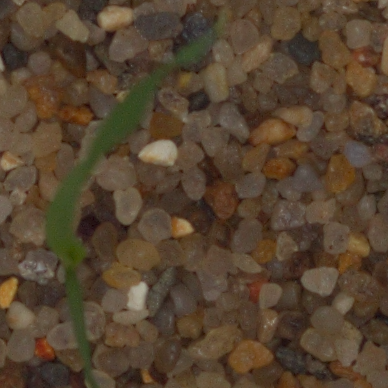

In [229]:
img = PIL.Image.open(f'{PATH}/train/{classes[0]}/{files[1]}'); img

In [230]:
img.size

(388, 388)

## Data pre-processing

In [245]:
from os import listdir
from os.path import join
train_path = f'{PATH}/train'

In [248]:
dirs = [d for d in listdir(train_path) if os.path.isdir(join(train_path,d))]
print(dirs)

['Common wheat', 'Sugar beet', 'Small-flowered Cranesbill', 'Shepherds Purse', 'Cleavers', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Common Chickweed', 'Charlock', 'Fat Hen', 'Black-grass']


In [249]:
train_dict = {d: listdir(join(train_path,d)) for d in dirs}

In [234]:
train_dict.keys()

dict_keys(['Common wheat', 'Sugar beet', 'Small-flowered Cranesbill', 'Shepherds Purse', 'Cleavers', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Common Chickweed', 'Charlock', 'Fat Hen', 'Black-grass'])

In [235]:
sum(len(v) for v in train_dict.values())

4750

In [252]:
with open(f'{PATH}/train.csv', 'w') as csv:
    csv.write('img,label\n')
    for d in dirs:
        for f in train_dict[d]: csv.write(f'{f},{d.replace(" ", "_")}\n')

In [253]:
!head {PATH}/train.csv

img,label
d9e0c6708.png,Common_wheat
9bcfd14d6.png,Common_wheat
3dc5876a5.png,Common_wheat
f3743e142.png,Common_wheat
75d126b6e.png,Common_wheat
926be1c1b.png,Common_wheat
94cb20fd9.png,Common_wheat
d174ffbad.png,Common_wheat
fe8affe51.png,Common_wheat


In [254]:
!wc -l {PATH}/train.csv

4751 data/plant-seedlings-classification/train.csv


In [255]:
img_path = f'{PATH}/images'
os.makedirs(img_path, exist_ok=True)

In [241]:
!cp {PATH}/train/*/*.png {PATH}/images/

In [242]:
!ls {PATH}/images | wc -l

4750


## Our first model: quick start

In [6]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [256]:
arch=resnet34
bs=64
sz=224
csv_fname = os.path.join(PATH, "train.csv")
train_labels = list(open(csv_fname))
n = len(list(open(csv_fname)))-1
val_idxs = get_cv_idxs(n)
tfms = tfms_from_model(arch, sz)
data = ImageClassifierData.from_csv(PATH, "images", csv_fname, bs, tfms, val_idxs, test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.567052   0.87696    0.720023  
    1      1.097612   0.701934   0.752238                 



[0.70193356, 0.7522376537322998]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 48%|████▊     | 29/60 [00:00<00:01, 30.15it/s, loss=3.29] 


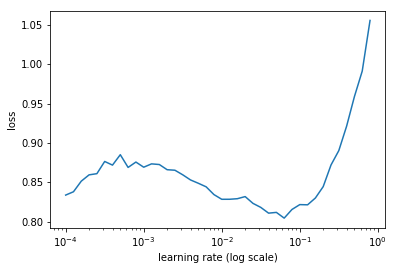

In [257]:
lrf=learn.lr_find()
learn.sched.plot()

In [258]:
learn.fit(0.1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      1.051945   0.677068   0.761227  
    1      1.01142    0.605626   0.78017                  
    2      0.909429   0.555445   0.828858                  
    3      0.779238   0.532567   0.830363                  



[0.53256655, 0.8303626537322998]

### Data augmentation

In [259]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [260]:
def get_augs():
    data = ImageClassifierData.from_csv(PATH, "images", csv_fname, bs, tfms, val_idxs)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [261]:
ims = np.stack([get_augs() for i in range(6)])

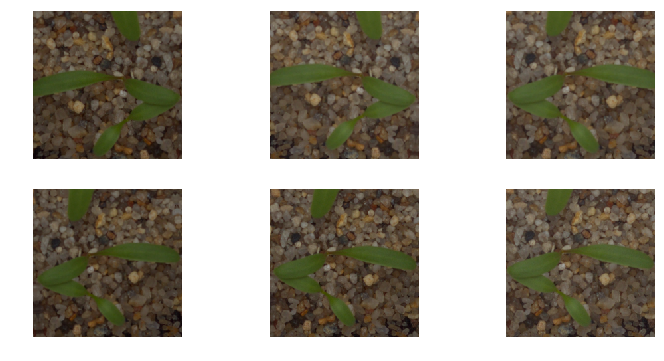

In [262]:
plots(ims, rows=2)

In [263]:
data = ImageClassifierData.from_csv(PATH, 'images', csv_fname, bs, tfms, val_idxs, test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [264]:
learn.fit(0.1, 4, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.514566   0.765117   0.719174  
    1      1.2574     0.728009   0.738503                 
    2      0.966778   0.578522   0.784336                  
    3      0.887579   0.5571     0.797878                  
    4      0.75991    0.518629   0.810185                  
    5      0.652937   0.467184   0.829321                  
    6      0.579002   0.453314   0.833681                  
    7      0.656429   0.507978   0.815123                  
    8      0.660862   0.482566   0.801466                  
    9      0.627364   0.435104   0.846181                  
    10     0.561233   0.407591   0.846836                  
    11     0.51689    0.388619   0.856597                  
    12     0.476584   0.389397   0.856404                  
    13     0.441597   0.375476   0.872608                  
    14     0.435168   0.367669   0.873457                  



[0.36766908, 0.8734567920366924]

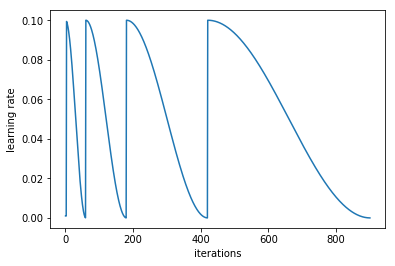

In [265]:
learn.sched.plot_lr()

In [266]:
learn.save('224_plants_lastlayer')

In [267]:
learn.load('224_plants_lastlayer')

### Fine-tuning and differential learning rate annealing

In [268]:
learn.unfreeze()

In [269]:
lr=np.array([0.1/9,0.1/3,0.1])

In [270]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.814718   0.389189   0.848843  
    1      0.572631   0.59449    0.813889                  
    2      0.342826   0.191892   0.929437                  
    3      0.318149   0.261035   0.897994                  
    5      0.184601   0.126948   0.955864                  
    6      0.1405     0.115793   0.956906                  



[0.11579254, 0.9569058656692505]

In [271]:
learn.save('224_plants_all')

In [272]:
learn.load('224_plants_all')

In [273]:
(learn.data.test_dl == None)

False

In [277]:
log_preds,y = learn.TTA(is_test=True)

In [278]:
log_preds.shape

(5, 794, 12)

In [279]:
probs = np.exp(log_preds)

In [280]:
probs.shape

(5, 794, 12)

In [281]:
type(probs)

numpy.ndarray

In [282]:
ps = np.exp(probs)

In [287]:
len(np.argmax(ps[0], axis=1))

794

In [288]:
df = pd.DataFrame(np.argmax(ps[0], axis=1))

In [289]:
df.insert(0, 'file', [f[5:] for f in data.test_ds.fnames])

In [290]:
df.columns = ['file', 'species']

In [291]:
class_dict = {i: d for i,d in enumerate(data.classes)}

In [292]:
class_dict

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common_Chickweed',
 4: 'Common_wheat',
 5: 'Fat_Hen',
 6: 'Loose_Silky-bent',
 7: 'Maize',
 8: 'Scentless_Mayweed',
 9: 'Shepherds_Purse',
 10: 'Small-flowered_Cranesbill',
 11: 'Sugar_beet'}

In [293]:
df.head()

,file,species
0,12625488b.png,5
1,c832e4302.png,5
2,e82017baa.png,6
3,c10ccbd82.png,8
4,8b27bfd2b.png,10


In [294]:
df["species"] = df["species"].map(class_dict.get)

In [295]:
df.head()

,file,species
0,12625488b.png,Fat_Hen
1,c832e4302.png,Fat_Hen
2,e82017baa.png,Loose_Silky-bent
3,c10ccbd82.png,Scentless_Mayweed
4,8b27bfd2b.png,Small-flowered_Cranesbill


In [296]:
df["species"] = df["species"].map(lambda s: s.replace("_", " "))

In [297]:
df.head()

,file,species
0,12625488b.png,Fat Hen
1,c832e4302.png,Fat Hen
2,e82017baa.png,Loose Silky-bent
3,c10ccbd82.png,Scentless Mayweed
4,8b27bfd2b.png,Small-flowered Cranesbill


In [298]:
SUBM = f'{PATH}/subm'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}/subm2.gz', compression='gzip', index=False)

In [299]:
FileLink(f'{SUBM}/subm2.gz')

/home/ubuntu/fastai/courses/dl1/data/plant-seedlings-classification/subm/subm2.gz

## Review: easy steps to train a world-class image classifier

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

## Analyzing results: loss and accuracy

When we run `learn.fit` we print 3 performance values (see above.) Here 0.03 is the value of the **loss** in the training set, 0.0226 is the value of the loss in the validation set and 0.9927 is the validation accuracy. What is the loss? What is accuracy? Why not to just show accuracy?

**Accuracy** is the ratio of correct prediction to the total number of predictions.

In machine learning the **loss** function or cost function is representing the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by:
`-(y * log(p) + (1-y) * log (1-p))`
where `y` is the true label of `x` and `p` is the probability predicted by our model that the label is 1.

In [34]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [35]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

Note that in our toy example above our accuracy is 100% and our loss is 0.16. Compare that to a loss of 0.03 that we are getting while predicting cats and dogs. Exercise: play with `preds` to get a lower loss for this example. 

**Example:** Here is an example on how to compute the loss for one example of binary classification problem. Suppose for an image x with label 1 and your model gives it a prediction of 0.9. For this case the loss should be small because our model is predicting a label $1$ with high probability.

`loss = -log(0.9) = 0.10`

Now suppose x has label 0 but our model is predicting 0.9. In this case our loss should be much larger.

loss = -log(1-0.9) = 2.30

- Exercise: look at the other cases and convince yourself that this make sense.
- Exercise: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximize accuracy? The binary classification loss is an easier function to optimize.

## Single prediction

In [ ]:
trn_tfms,val_tfms = tfms_from_model(arch, sz)
img = val_tfms(Image.open(PATH+img_path))
learn.predict_array(img[None]))
np.argmax(preds)